In [1]:
import utils
import numpy as np
import math
import scipy
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import bayesflow as bf
import tensorflow as tf
import tensorflow_probability as tfp
# Set TensorFlow to use only the CPU
tf.config.set_visible_devices([], 'GPU')

cor, pal = utils.matplotlib_style()

# Set random seed
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

/Users/mrazo/Library/Caches/pypoetry/virtualenvs/scrappy-jDg5b02t-py3.11/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Two-state promoter distribution

In this notebook, we will explore training a `BayesFlow` neural network to
perform parametric inference on the biophysical parameters of a two-state
promoter model. The two-state promoter model, also known as the "telegraph
model", is a simple model of gene expression that describes the dynamics of a
promotion region that can be in one of two states: active or inactive. The
steady mRNA distribution can be obtained by solving the master equation for the
system. The solution has a closed form and is given by:

$$
{\scriptstyle
P\left(m \mid k^{(p)}_{\text{on}}, k^{(p)}_{\text{off}}, r_m, \gamma_m\right) =
\frac{1}{\Gamma(m + 1)}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m} + m
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}}}{\gamma_m}
    \right)
}
\frac{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m}
    \right)
}{
    \Gamma
    \left(
        \frac{k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}}}{\gamma_m} + m 
    \right)
}
\left( \frac{r_m}{\gamma_m} \right)^m \\
\times {}_1F_1 
\left(
    \frac{
            k^{(p)}_{\text{on}} 
        }{
            \gamma_m
        }
    + m,
    \frac{
            k^{(p)}_{\text{on}} + k^{(p)}_{\text{off}} 
        }{
            \gamma_m
        }
    + m,
    - \frac{r_m}{\gamma_m}
\right),
}
\tag{1}
$$


where $m$ is the steady-state mRNA copy number per cell, $k_on^{(p)}$ and
$k_off^{(p)}$ are the rate constants for the promoter turning on and off,
respectively, $r_m$ is the mRNA production rate, and $\gamma_m$ is the mRNA
degradation rate.

The challenge to evaluate this distribution is that the confluent hypergeometric
function $_1F_1$ can be numerically unstable in certain parameter regimes. In a
separate notebook, we explored asymptotic approximations to the confluent
hypergeometric function, allowing us to tackle this problem. Here, we will focus
on setting up a neural network to perform inference on the parameters of the
model.

But before getting to that, let's show the steady-state mRNA distribution for
a parameter regime to make sure all functions previously-defined are working.

Text(0, 0.5, 'Probability')

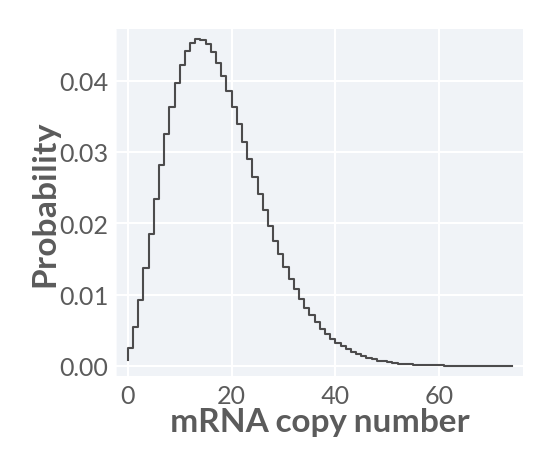

In [3]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 100.0

# Define range of mRNA
m_range = np.arange(0, 75)

# Evaluate the log probability
logP = utils.two_state_log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

This looks excellent. Let's try again with a more challenging parameter regime.

Text(0, 0.5, 'Probability')

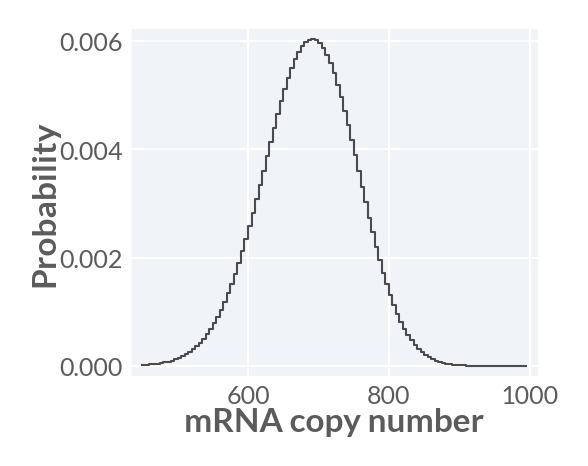

In [4]:
# Define parameters
k_on = 40.0
k_off = 18.0
r_m = 1000.0

# Define range of mRNA
m_range = np.arange(450, 1000, 5)

# Evaluate the log probability
logP = utils.two_state_log_probability(m_range, k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range, np.exp(logP))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

Again, everything looks in order. Let's now move on to setting the `BayesFlow`
neural network.

## Prior distribution function

Let's define the function that samples parameters from the prior distribution.

In [5]:
def prior_fn():
    """
    Generate prior samples for the parameters of a two-state promoter model.

    This function generates prior samples for the parameters `k_on`, `k_off`,
    and `r` based on specified distributions:
        - `k_on` is sampled from a log-normal distribution with mean 1 and
          standard deviation 1.
        - `k_off` is sampled from a gamma distribution with shape parameter 2
          and scale parameter 2.
        - `r` is sampled from a log-normal distribution with mean 3 and standard
          deviation 3.

    Returns
    -------
    - numpy.ndarray: A 1D array of shape (3,) containing the sampled parameters
      as float32.
        - `k_on` (float32): Sampled rate of activation of the promoter.
        - `k_off` (float32): Sampled rate of deactivation of the promoter.
        - `r` (float32): Sampled production rate of the mRNA.
    """
    # Prior on k_on rate
    log_k_on = rng.normal(1, 1)
    # Prior on k_off rate
    log_k_off = rng.normal(1, 1)
    # Prior on rate of transcription r
    log_r = rng.normal(2, 2)

    return np.float32(np.array([log_k_on, log_k_off, log_r]))

We can now define the `BayesFlow` `simulation.Prior` object and sample from the
prior distribution.

In [6]:
# Define parameter names
param_names = ['log_k_on', 'log_k_off', 'log_r']

# Define prior simulator
prior = bf.simulation.Prior(
    prior_fun=prior_fn,
    param_names=param_names,
)

# Draw samples from the prior
prior(10)

{'prior_draws': array([[ 1.3047171 , -0.03998411,  3.5009024 ],
        [ 1.9405648 , -0.9510352 , -0.60435903],
        [ 1.1278404 ,  0.6837574 ,  1.9663976 ],
        [ 0.14695607,  1.879398  ,  3.555584  ],
        [ 1.0660307 ,  2.1272411 ,  2.9350188 ],
        [ 0.14070754,  1.3687508 ,  0.0822348 ],
        [ 1.8784503 ,  0.9500741 ,  1.6302752 ],
        [ 0.31907046,  2.2225413 ,  1.6909411 ],
        [ 0.5716722 ,  0.6478664 ,  3.0646183 ],
        [ 1.3654441 ,  1.4127326 ,  2.8616421 ]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

## Likelihood function

Next, we can define the likelihood function. This function takes as input the
log parameters and simulates a dataset by sampling from the likelihood function
conditioned on the parameters. The likelihood function is given by the steady
state mRNA distribution described above in Eq. (1).

### Naive likelihood function

For the first attempt, we will try to compute the likelihood function by 
evaluating the log probability of the mRNA copy number given the parameters for
a fixed range of mRNA copy numbers. After having these probabilities, we can
sample from the distribution to simulate UMI counts.

In [7]:
def likelihood_fn(params, n_obs=10_000, m_range=range(0, 2_000)):
    """
    Generate random samples based on the mRNA distribution for a two-state
    promoter model.

    This function computes the log probabilities of mRNA copy numbers over a
    specified range, converts them to probabilities, normalizes these
    probabilities, and then generates random samples using these probabilities
    as weights. The output is a 3D tensor of samples.

    Parameters
    ----------
    - params (tuple): A tuple containing (log_k_on, log_k_off, log_r)
        - log_k_on (float): Log of the rate of activation of the promoter.
        - log_k_off (float): Log of the rate of deactivation of the promoter.
        - log_r (float): Log of the production rate of the mRNA.
    - n_obs (int, optional): Number of observations to generate. Default is
      10,000.
    - m_range (range, optional): Range of mRNA copy numbers to consider. Default
      is range(0, 2,000).

    Returns
    -------
    - numpy.ndarray: A 3D tensor of shape (n_obs, 1) containing the generated
      samples as float32.
    """
    # Unpack parameters and exponentiate them
    k_on, k_off, r = np.exp(params)
    # Compute the log probability over m_range
    logP = utils.two_state_log_probability(m_range, k_on, k_off, r)
    # Convert log probabilities to probabilities
    P = np.exp(logP)
    # Normalize the probabilities to use as weights. This is necessary because
    # of numerical precision issues.
    P /= P.sum()
    # Generate random samples using these weights
    u = np.random.choice(m_range, size=n_obs, p=P)
    # Add a 3rd dimension to the array to make output 3D tensor
    u = np.expand_dims(u, axis=1)
    # Return the samples as float32
    return np.float32(u)

Let's define the `BayesFlow` `simulation.Simulator` object and the generative
model.

In [8]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Next, let's time how long it takes to simulate 10 datasets.

In [9]:
%time model(10)

CPU times: user 1.83 s, sys: 17.2 ms, total: 1.85 s
Wall time: 1.85 s


{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[ 0.88605255,  0.15984352,  0.35103756],
        [ 1.6505928 ,  1.7432542 ,  3.0863085 ],
        [ 0.3344903 ,  1.2321613 ,  2.2333717 ],
        [ 1.2186886 ,  1.8714287 ,  2.447191  ],
        [ 1.6789136 ,  1.067579  ,  2.5782387 ],
        [ 1.6312882 , -0.45715582,  1.3606576 ],
        [ 0.5296273 ,  0.36112216,  1.4497155 ],
        [ 2.4949412 ,  0.13416888,  3.9365568 ],
        [-0.6828698 ,  0.665115  ,  2.3255062 ],
        [ 1.5862223 ,  1.7112266 ,  3.5866945 ]], dtype=float32),
 'sim_non_batchable_context': None,
 'sim_batchable_context': None,
 'sim_data': array([[[ 3.],
         [ 4.],
         [ 0.],
         ...,
         [ 0.],
         [ 2.],
         [ 0.]],
 
        [[ 9.],
         [15.],
         [10.],
         ...,
         [ 5.],
         [14.],
         [ 9.]],
 
        [[ 7.],
         [ 4.],
         [ 0.],
         ...,
         [ 1.],
         [ 0.],
      

The time varies every time we run this simulation. The precision to compute the
confluent hypergeometric function is the main factor that determines the time it
takes to simulate the data.

The time it takes to evaluate 1000 ranges is noticeably longer. Furthermore,
depending on the parameters of the model, many of these evaluations are 
meaningless. It would be beneficial to have an "adaptive" likelihood function
that increases the number of bins on which to evaluate the distribution based on
the parameters.

To do this we must first define a function that defines the bins on which to
evaluate the log probability iteratively. This function will start with a
default number of bins and only increase the number of bins if the cumulative
probability hasn't reached a certain threshold.

In [ ]:
def adaptive_m_range(
    k_on, k_off, r, gm=1, tol=1e-5, max_m=2000, step=25, initial_range=100
):
    """
    Adaptively determine the range of mRNA copy numbers (m_range) for the mRNA
    distribution based on the given parameters and a tolerance for cumulative
    probability.

    Parameters
    ----------
    - k_on (float): Rate of activation of the promoter.
    - k_off (float): Rate of deactivation of the promoter.
    - r (float): Production rate of the mRNA.
    - gm (float, optional): mRNA degradation rate. Default is 1.
    - tol (float, optional): Tolerance for cumulative probability. Default is
      1e-5.
    - max_m (int, optional): Maximum mRNA copy number to consider. Default is
      1000.
    - step (int, optional): Step size for mRNA copy number increments. Default
      is 10.
    - initial_range (int, optional): Initial range of mRNA copy numbers to
      consider. Default is 200.

    Returns
    -------
    - m_range (numpy.ndarray): Array of mRNA copy numbers to consider.
    - log_probs (numpy.ndarray): Array of log probabilities corresponding to
      m_range.
    """
    # Initialize list to store mRNA copy numbers
    m_values = []
    # Initialize list to store log probabilities
    log_probs = []
    # Initialize cumulative probability
    cumulative_prob = 0
    # Start with mRNA copy number 0
    m = 0

    # Generate the initial range of mRNA copy numbers
    initial_m_range = np.arange(m, initial_range)
    # Compute log probabilities for the initial range
    initial_log_probs = np.array(
        [log_p_m(mi, k_on, k_off, r, gm) for mi in initial_m_range]
    )

    # Append the initial range of mRNA copy numbers to the list
    m_values.extend(initial_m_range)
    # Append the initial log probabilities to the list
    log_probs.extend(initial_log_probs)

    # Convert log probabilities to probabilities
    initial_prob_chunk = np.exp(initial_log_probs)
    # Update cumulative probability
    cumulative_prob += np.sum(initial_prob_chunk)

    # Increment m by the initial range size
    m = initial_range

    # Loop until cumulative probability reaches (1 - tol) or m exceeds max_m
    while cumulative_prob < (1 - tol) and m < max_m:
        # Generate a chunk of mRNA copy numbers
        m_chunk = np.arange(m, m + step)
        # Compute log probabilities for the current chunk
        log_prob_chunk = np.array(
            [log_p_m(mi, k_on, k_off, r, gm) for mi in m_chunk]
        )
        # Break the loop if any of the probabilities in the chunk are infinite
        if np.any(np.isinf(log_prob_chunk)):
            break

        # Append the current chunk of mRNA copy numbers to the list
        m_values.extend(m_chunk)
        # Append the current chunk of log probabilities to the list
        log_probs.extend(log_prob_chunk)

        # Convert log probabilities to probabilities
        prob_chunk = np.exp(log_prob_chunk)
        # Update cumulative probability
        cumulative_prob += np.sum(prob_chunk)

        # Break the loop if all probabilities in the chunk are NaN
        if np.all(np.isnan(prob_chunk)):
            break

        # Increment m by the step size
        m += step

    # Return the mRNA copy numbers and corresponding log probabilities as numpy
    # arrays
    return np.array(m_values), np.array(log_probs)

With this function in place, depending on the parameter values, we can evaluate
the likelihood function with a different number of bins, potentially saving
computation time. Let's test this function.

In [ ]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 103

# Adaptively determine the range of mRNA copy numbers
m_range = adaptive_m_range(k_on, k_off, r_m)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range[0], np.exp(m_range[1]))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

For this set of parameters the function evaluated all the way to the initial 
range, so it didn't need adaptation. Let's try another set of parameters.

In [ ]:
# Define parameters
k_on = 4.0
k_off = 18.0
r_m = 1000

# Adaptively determine the range of mRNA copy numbers
m_range = adaptive_m_range(k_on, k_off, r_m)

print(np.sum(np.exp(m_range[1])))

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Plot the probability
ax.step(m_range[0], np.exp(m_range[1]))

# Label axis
ax.set_xlabel("mRNA copy number")
ax.set_ylabel("Probability")

In [ ]:
def adaptive_m_range(k_on, k_off, r, gm=1, tol=1e-5, max_m=1000, step=10, initial_range=200):
    """
    Adaptively determine the range of mRNA copy numbers (m_range) for the mRNA
    distribution based on the given parameters and a tolerance for cumulative
    probability.

    Parameters
    ----------
    - k_on (float): Rate of activation of the promoter.
    - k_off (float): Rate of deactivation of the promoter.
    - r (float): Production rate of the mRNA.
    - gm (float, optional): mRNA degradation rate. Default is 1.
    - tol (float, optional): Tolerance for cumulative probability. Default is
      1e-5.
    - max_m (int, optional): Maximum mRNA copy number to consider. Default is
      1000.
    - step (int, optional): Step size for mRNA copy number increments. Default
      is 10.
    - initial_range (int, optional): Initial range of mRNA copy numbers to consider. Default is 200.

    Returns
    -------
    - m_range (numpy.ndarray): Array of mRNA copy numbers to consider.
    - log_probs (numpy.ndarray): Array of log probabilities corresponding to
      m_range.
    """
    # Initialize list to store mRNA copy numbers
    m_values = []
    # Initialize list to store log probabilities
    log_probs = []
    # Initialize cumulative probability
    cumulative_prob = 0
    # Start with mRNA copy number 0
    m = 0

    # Generate the initial range of mRNA copy numbers
    initial_m_range = np.arange(m, initial_range)
    # Compute log probabilities for the initial range
    initial_log_probs = np.array(
        [log_p_m(mi, k_on, k_off, r, gm) for mi in initial_m_range])

    # Append the initial range of mRNA copy numbers to the list
    m_values.extend(initial_m_range)
    # Append the initial log probabilities to the list
    log_probs.extend(initial_log_probs)

    # Convert log probabilities to probabilities
    initial_prob_chunk = np.exp(initial_log_probs)
    # Update cumulative probability
    cumulative_prob += np.sum(initial_prob_chunk)

    # Increment m by the initial range size
    m = initial_range

    # Loop until cumulative probability reaches (1 - tol) or m exceeds max_m
    while cumulative_prob < (1 - tol) and m < max_m:
        # Generate a chunk of mRNA copy numbers
        m_chunk = np.arange(m, m + step)
        # Compute log probabilities for the current chunk
        log_prob_chunk = np.array(
            [log_p_m(mi, k_on, k_off, r, gm) for mi in m_chunk])

        # Append the current chunk of mRNA copy numbers to the list
        m_values.extend(m_chunk)
        # Append the current chunk of log probabilities to the list
        log_probs.extend(log_prob_chunk)

        # Convert log probabilities to probabilities
        prob_chunk = np.exp(log_prob_chunk)
        # Update cumulative probability
        cumulative_prob += np.sum(prob_chunk)

        # Increment m by the step size
        m += step

        # Break the loop if all probabilities in the chunk are NaN
        if np.all(np.isnan(prob_chunk)):
            break

    # Return the mRNA copy numbers and corresponding log probabilities as numpy arrays
    return np.array(m_values), np.array(log_probs)

It takes a little longer, but it is still reasonable. Let's try to simulate 100
datasets.

In [ ]:
# Define the number of draws
n_draws = 100
# Draw samples from the generative model
%time model_draws = model(n_draws)

Now, let's plot the simulated data ECDFs.

In [ ]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Loop through the draws and plot the data
for m in range(n_draws):
    sns.ecdfplot(model_draws["sim_data"][:, m, :].flatten(), ax=ax)

# Set x-axis to log scale
ax.set_xscale("log")

# Label axis
ax.set_xlabel("UMI counts")
ax.set_ylabel("ECDF")

This covers a wide range of mRNA copy numbers. 

Next, we define the summary network. For this, we will try the `DeepSet` network
architecture.

In [ ]:
# Define summary network as a Deepset
summary_net = bf.networks.DeepSet(summary_dim=8)

# Simulate a pass through the summary network
summary_pass = summary_net(model(1)["sim_data"])

summary_pass.shape

In [ ]:
def adaptive_m_range(k_on, k_off, r, gm=1, tol=1e-5, max_m=1000, step=10):
    """
    Adaptively determine the range of mRNA copy numbers (m_range) for the mRNA
    distribution based on the given parameters and a tolerance for cumulative
    probability.

    Parameters
    ----------
    - k_on (float): Rate of activation of the promoter.
    - k_off (float): Rate of deactivation of the promoter.
    - r (float): Production rate of the mRNA.
    - gm (float, optional): mRNA degradation rate. Default is 1.
    - tol (float, optional): Tolerance for cumulative probability. Default is
      1e-6.
    - max_m (int, optional): Maximum mRNA copy number to consider. Default is
      1000.
    - step (int, optional): Step size for mRNA copy number increments. Default
      is 10.

    Returns
    -------
    - m_range (numpy.ndarray): Array of mRNA copy numbers to consider.
    - log_probs (numpy.ndarray): Array of log probabilities corresponding to
      m_range.
    """
    # Initialize list to store mRNA copy numbers
    m_values = []
    # Initialize list to store log probabilities
    log_probs = []
    # Initialize cumulative probability
    cumulative_prob = 0
    # Start with mRNA copy number 0
    m = 0

    # Loop until cumulative probability reaches (1 - tol) or m exceeds max_m
    while cumulative_prob < (1 - tol) and m < max_m:
        # Generate a chunk of mRNA copy numbers
        m_chunk = np.arange(m, m + step)
        # Compute log probabilities for the current chunk
        log_prob_chunk = np.array(
            [log_p_m(mi, k_on, k_off, r, gm) for mi in m_chunk]
        )

        # Append the current chunk of mRNA copy numbers to the list
        m_values.extend(m_chunk)
        # Append the current chunk of log probabilities to the list
        log_probs.extend(log_prob_chunk)

        # Convert log probabilities to probabilities
        prob_chunk = np.exp(log_prob_chunk)
        # Update cumulative probability
        cumulative_prob += np.sum(prob_chunk)

        # Increment m by the step size
        m += step

        # Break the loop if all probabilities in the chunk are NaN
        if np.all(np.isnan(prob_chunk)):
            break

    # Return the mRNA copy numbers and corresponding log probabilities as numpy
    # arrays
    return np.array(m_values), np.array(log_probs)

In [ ]:
def adaptive_likelihood_fn(params, n_obs=10_000, tol=1e-5, max_m=1000, step=10):
    """
    Likelihood function with adaptive m_range selection.

    This function generates random samples based on the mRNA distribution by
    adaptively determining the range of mRNA copy numbers (m_range) using the
    given parameters and a tolerance for cumulative probability.

    Parameters
    ----------
    - params (tuple): A tuple containing (k_on, k_off, r)
        - k_on (float): Rate of activation of the promoter.
        - k_off (float): Rate of deactivation of the promoter.
        - r (float): Production rate of the mRNA.
    - n_obs (int, optional): Number of observations to generate. Default is
      10,000.
    - tol (float, optional): Tolerance for cumulative probability in
      adaptive_m_range. Default is 1e-6.
    - max_m (int, optional): Maximum mRNA copy number to consider in
      adaptive_m_range. Default is 1000.
    - step (int, optional): Step size for mRNA copy number increments in
      adaptive_m_range. Default is 10.

    Returns
    -------
    - numpy.ndarray: Randomly generated samples based on the distribution.
    """
    # Unpack the parameters
    k_on, k_off, r = params

    # Adaptively determine the mRNA copy number range and corresponding log
    # probabilities
    m_range, log_probs = adaptive_m_range(
        k_on, k_off, r, tol=tol, max_m=max_m, step=step
    )

    # Convert log probabilities to probabilities

    # Find the maximum log probability for numerical stability
    max_log_prob = np.max(log_probs)
    # Exponentiate the log probabilities and normalize
    P = np.exp(log_probs - max_log_prob)
    # Normalize the probabilities to sum to 1
    P /= P.sum()

    # Generate random samples using the normalized probabilities as weights
    return np.float32(np.random.choice(m_range, size=n_obs, p=P))

In [ ]:
# def likelihood_fn(params, n_obs=10_000, m_range=range(0, 400)):
#     # Unpack parameters
#     k_on, k_off, r = params
#     # Compute the log probability over m_range
#     logP = [log_p_m(m, k_on, k_off, r) for m in m_range]
#     # Convert log probabilities to probabilities
#     P = np.exp(logP)
#     # Normalize the probabilities to use as weights
#     P /= P.sum()
#     # Generate random samples using these weights
#     return np.float32(np.random.choice(m_range, size=n_obs, p=P))

In [ ]:
# Define Likelihood simulator function for BayesFlow
simulator = bf.simulation.Simulator(simulator_fun=adaptive_likelihood_fn)

# Build generative model
model = bf.simulation.GenerativeModel(prior, simulator)

Let's look at the ECDF for multiple samples from the prior distribution.

In [ ]:
# Define the number of draws
n_draws = 100
# Draw samples from the generative model
model_draws = model(n_draws)

In [ ]:

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

# Loop through the draws and plot the data
for m in range(n_draws):
    sns.ecdfplot(model_draws["sim_data"][m, :], ax=ax)

# Label axis
ax.set_xlabel("UMI counts")
ax.set_ylabel("ECDF")